In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/experiments/cf`


In [ ]:
import ClimaAtmos as CA 
import ClimaAtmos.Parameters as CAP
using CairoMakie
using Glob
using NCDatasets
using Statistics
using Revise 
using Roots

[ Info: Precompiling ClimaAtmos [b2c96348-7fb7-4fe0-8da9-78d88439e717] (cache misses: wrong dep version loaded (4), wrong source (2), incompatible header (12))
[ Info: Precompiling AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6] 
┌ Info: Skipping precompilation due to precompilable error. Importing AbbrvStackTracesDistributedExt [c754d430-0e26-5385-8920-cd1da75574c6].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
┌ Warning: Timed out waiting for `Base.active_repl_backend.ast_transforms` to become available. Autoloads will not work.
└ @ BasicAutoloads ~/.julia/packages/BasicAutoloads/08hIo/src/BasicAutoloads.jl:117
[ Info: If you have a slow startup file, consider moving `register_autoloads` to the end of it.
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (8), incompatible header (10))


In [ ]:
# include helper functions
includet("mixing_length.jl")

In [3]:
# read in sample data 
# fpath = "/net/sampo/data1/zhaoyi/GCMForcedLES/cfsite/07/HadGEM2-A/amip/Output.cfsite17_HadGEM2-A_amip_2004-2008.07.4x/stats/Stats.cfsite17_HadGEM2-A_amip_2004-2008.07.nc"
# ds_profiles = NCDataset(fpath).group["profiles"];
# ds_timeseries = NCDataset(fpath).group["timeseries"];

In [4]:
# build a config to get the parameters
# config = CA.AtmosConfig("ClimaAtmos.jl/config/model_configs/prognostic_edmfx_bomex_pigroup_column.yml")
# params = CA.ClimaAtmosParameters(config)
# CAP.turbconv_params(params)

┌ Info: Making AtmosConfig with config files: 
│    /home/jschmitt/experiments/cf/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
└    ClimaAtmos.jl/config/model_configs/prognostic_edmfx_bomex_pigroup_column.yml


ClimaAtmos.Parameters.TurbulenceConvectionParameters{Float32, StaticArraysCore.SVector{12, Float32}, StaticArraysCore.SVector{2, Float32}}(0.07234781f0, 0.7f0, 1.0f-5, 0.056072097f0, 0.37396976f0, 5.6101217f0, 2.5f0, 1.4362168f0, 0.8242482f0, 4.076923f0, 0.8133326f0, 10.0f0, 0.1f0, 1.5f0, 500.0f0, 0.06277435f0, 36.114597f0, 0.00018836212f0, 1.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, Float32[-1.2633841, -0.4599816, -0.46293145, 1.4203615, 0.56424814, 0.32604897, -0.09664796, 0.72201914, 0.16903223, 3.2461705, -1.0280044, 0.34029284], Float32[0.08116105, 6497.8247], 0.0f0, 1.0f0, 0.0f0, 10.0f0, 0.0f0, 10.0f0)

┌ Warning: Timed out waiting for `Base.active_repl_backend.ast_transforms` to become available. Autoloads will not work.
└ @ BasicAutoloads ~/.julia/packages/BasicAutoloads/08hIo/src/BasicAutoloads.jl:117
[ Info: If you have a slow startup file, consider moving `register_autoloads` to the end of it.


In [42]:
# Write profile names to a text file
open("timeseries_names.txt", "w") do io
    for name in collect(keys(ds_timeseries))
        println(io, name)
    end
end

In [8]:
ar = CA.turbulent_prandtl_number.(params, 
                            ds_profiles["buoyancy_frequency_mean2"][:, :],
                            ds_profiles["strain_rate_magnitude"][:, :]);

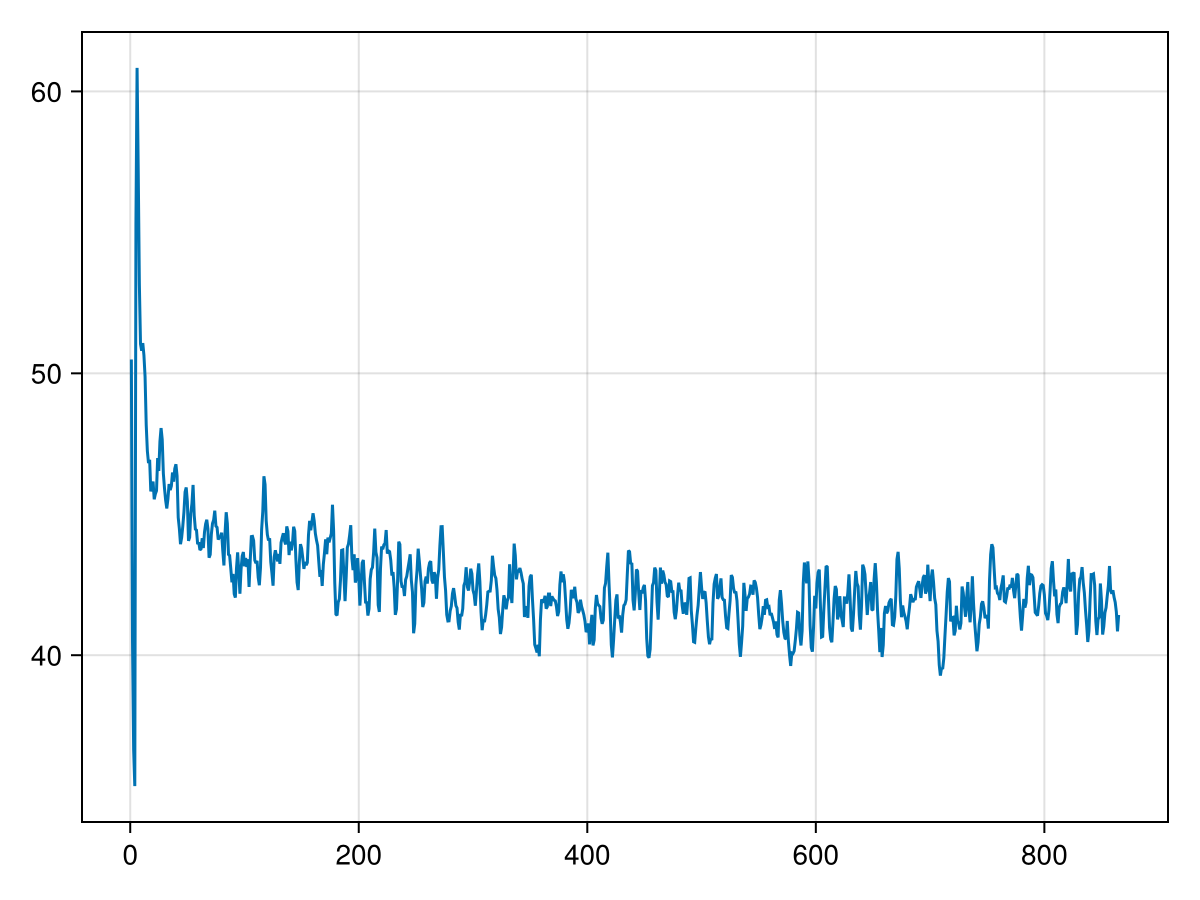

In [110]:
function tke(ds)
    return (ds["w_mean2"][:, :] .+ ds["v_mean2"][:, :] .+ ds["u_mean2"][:, :]) ./2
end

lines(tke(ds_profiles)[1, :]) # surface tke timeseries


- `params`: Parameter set (e.g., CLIMAParameters.AbstractParameterSet).
- `ustar`: Friction velocity [m/s].
- `ᶜz`: Cell center height [m].
- `z_sfc`: Surface elevation [m].
- `ᶜdz`: Cell vertical thickness [m].
- `sfc_tke`: TKE near the surface (e.g., first cell center) [m^2/s^2].
- `ᶜlinear_buoygrad`: N^2, Brunt-Väisälä frequency squared [1/s^2].
- `ᶜtke`: Turbulent kinetic energy at cell center [m^2/s^2].
- `obukhov_length`: Surface Monin-Obukhov length [m].
- `ᶜstrain_rate_norm`: Frobenius norm of strain rate tensor [1/s].
- `ᶜPr`: Turbulent Prandtl number [-].
- `ᶜtke_exch`: TKE exchange term [m^2/s^3].
- `scale_blending_method`: The method to use for blending physical scales.

In [111]:
# get z and t dimension sizes to make resizing more clear
function add_z_dim(ds, varname, ds_profs = ds_profiles)
    repeat(ds[varname][:]', ds_profs.dim["z"], 1)
end
add_z_dim(ds_timeseries, "friction_velocity_mean")

function add_t_dim(ds, varname, ds_profs = ds_profiles)
    repeat(ds[varname][:], 1, ds_profs.dim["t"])
end
add_t_dim(ds_profiles, "z");


In [112]:
params = CA.ClimaAtmosParameters(config)
# ustar = ds_timeseries["friction_velocity_mean"][:]
# ustar = repeat(ustar', 200, 1)
ustar = add_z_dim(ds_timeseries, "friction_velocity_mean")
# ᶜz = ds_profiles["z"][:]
ᶜz = add_t_dim(ds_profiles, "z")
# over ocean surface elevation is zero
z_sfc = 0
ᶜdz = ᶜz[2] - ᶜz[1]
sfc_tke = repeat(tke(ds_profiles)[1, :]', ds_profiles.dim["z"], 1)
ᶜlinear_buoygrad = ds_profiles["buoyancy_frequency_mean2"][:, :]
ᶜtke = tke(ds_profiles)
obukhov_length = add_z_dim(ds_timeseries, "obukhov_length_mean")
ᶜstrain_rate_norm = ds_profiles["strain_rate_magnitude"][:, :]
ᶜPr = CA.turbulent_prandtl_number.(params, 
                            ds_profiles["buoyancy_frequency_mean2"][:, :],
                            ds_profiles["strain_rate_magnitude"][:, :])
ᶜtke_exch = zeros(size(ᶜz));

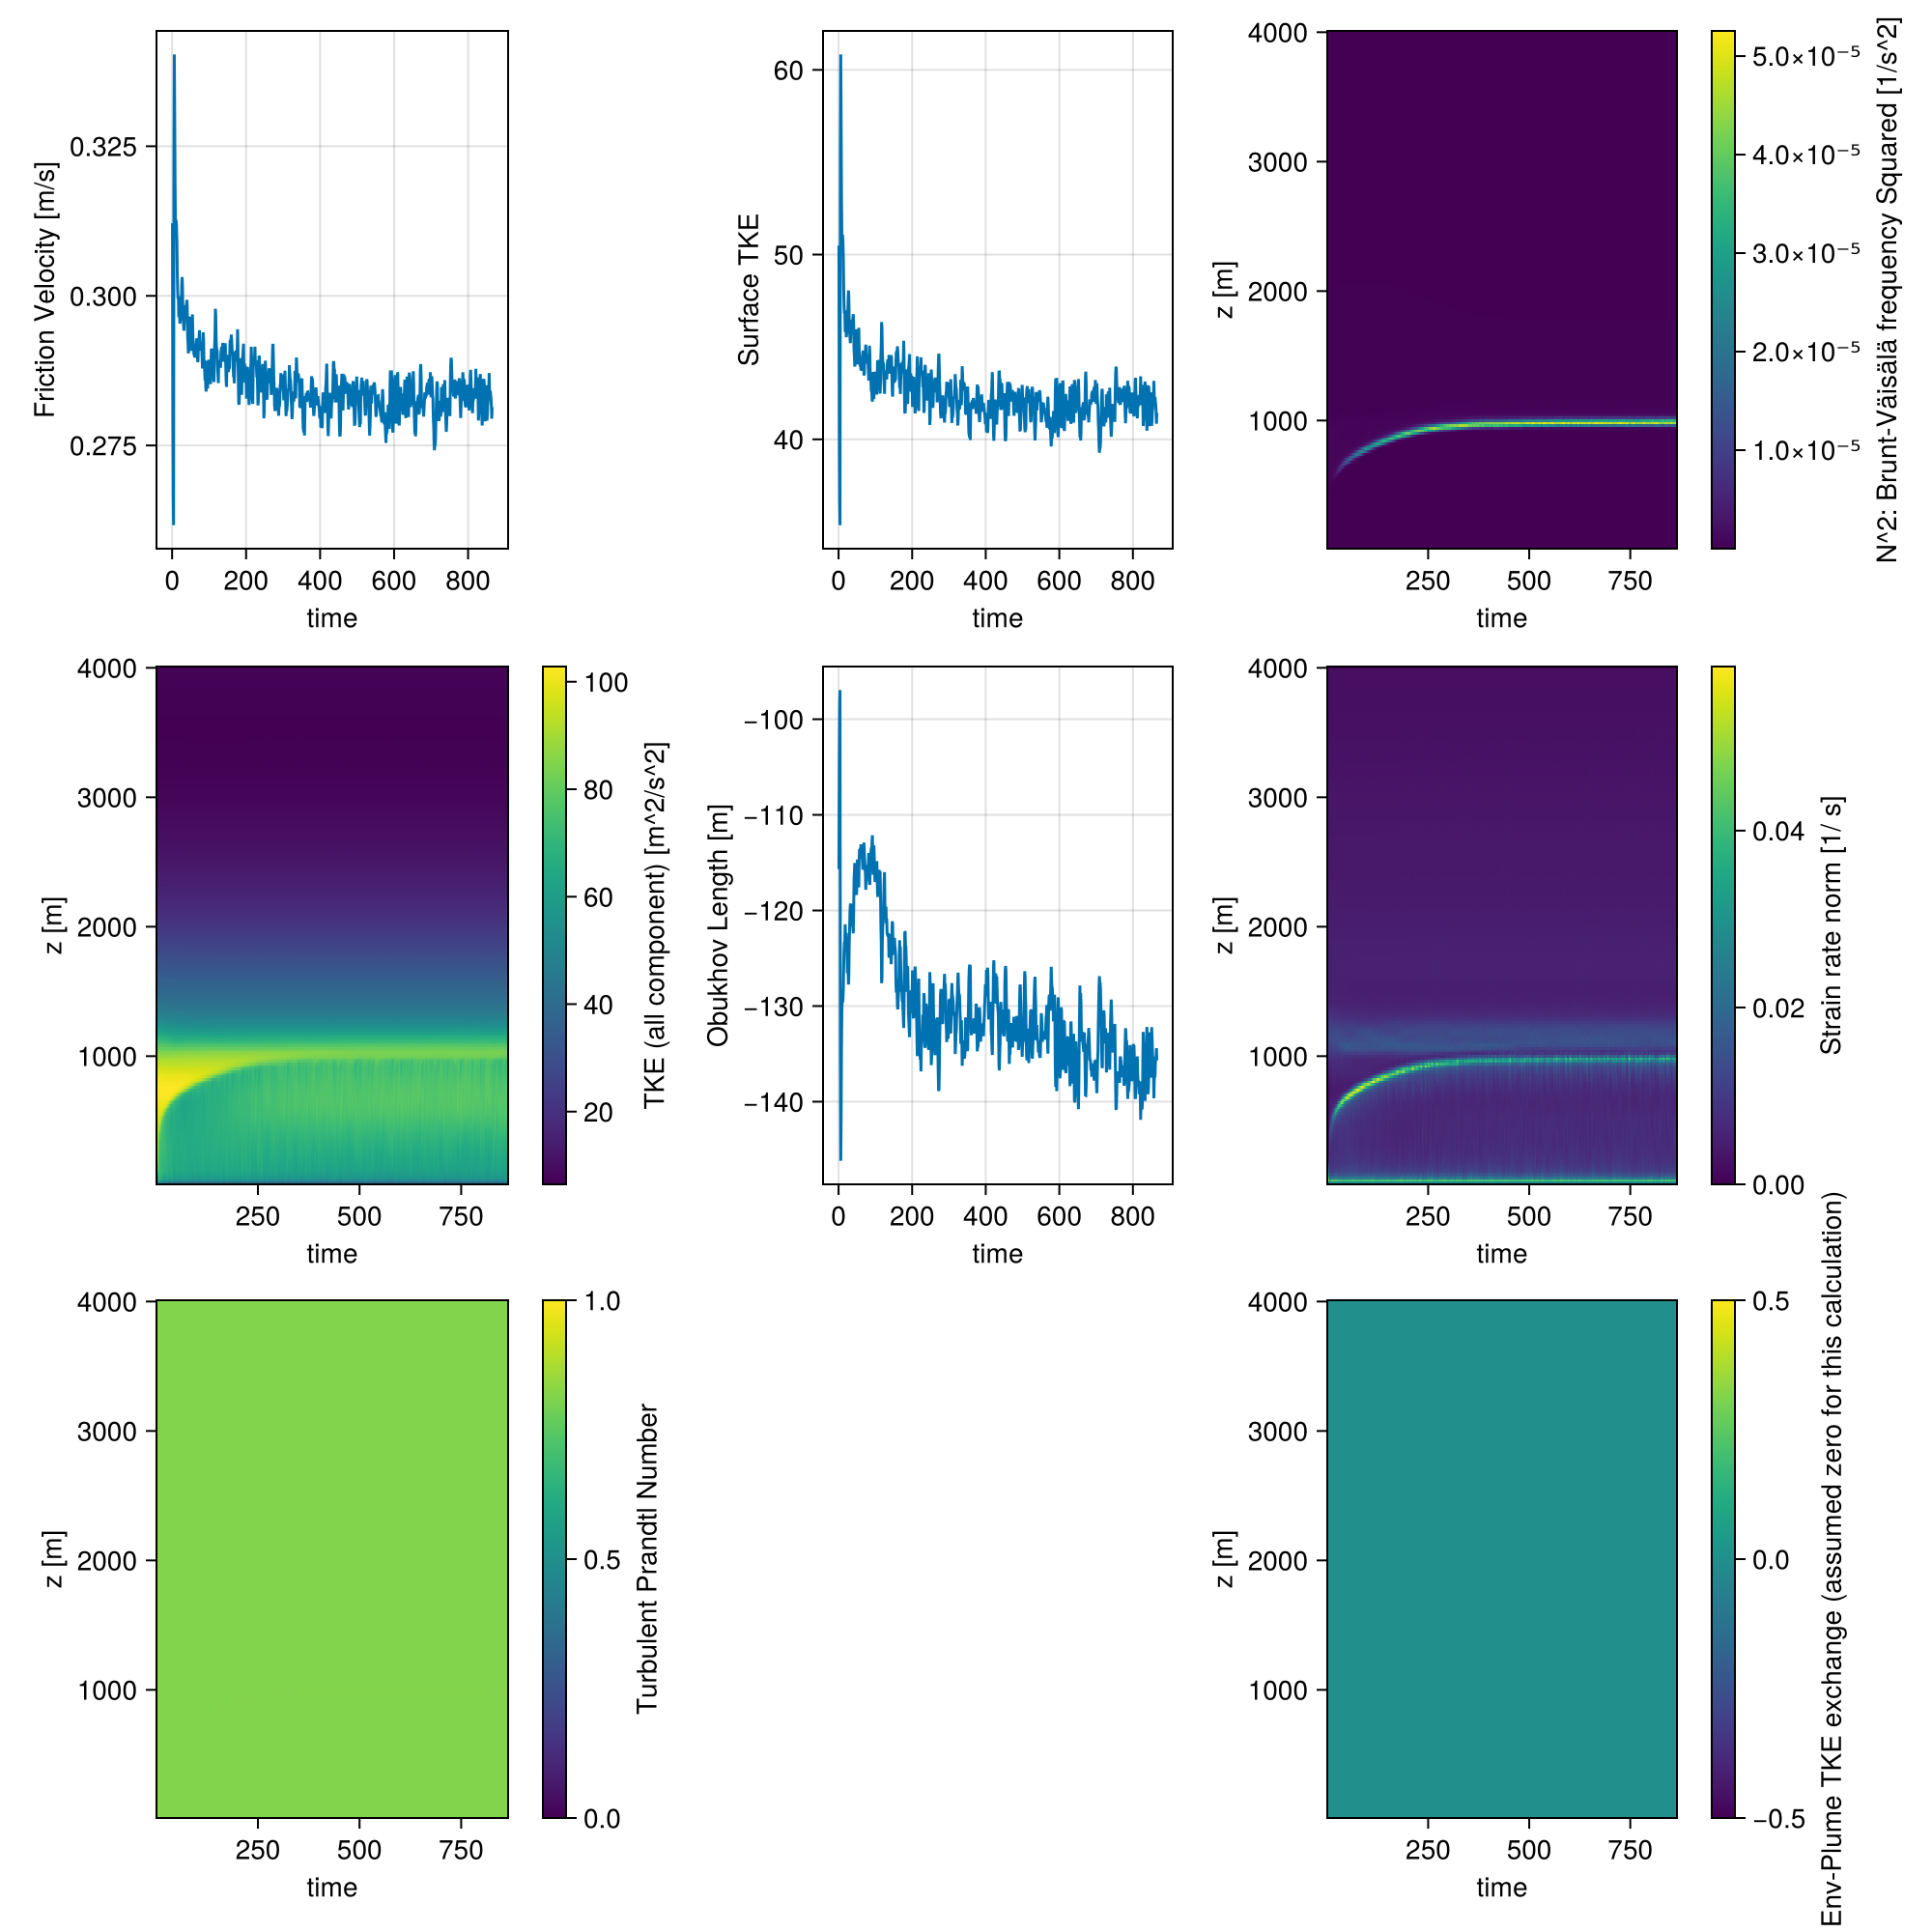

In [113]:
# ustar = ds_timeseries["friction_velocity_mean"][:]
# heatmap(repeat(ustar', 200, 1))
# heatmap(repeat(ᶜz, 1, 865))
fig = Figure(size = (1000, 1000))

ax = Axis(fig[1, 1], ylabel = "Friction Velocity [m/s]", xlabel = "time")
lines!(ax, ds_timeseries["friction_velocity_mean"][:])

ax = Axis(fig[1, 3], ylabel = "Surface TKE", xlabel = "time")
lines!(ax, tke(ds_profiles)[1, :]'[:])

ax = Axis(fig[1, 4], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(ᶜlinear_buoygrad')[1], ds_profiles["z"][:], ᶜlinear_buoygrad')
Colorbar(fig[1,5], hm, label = "N^2: Brunt-Väisälä frequency Squared [1/s^2]")

ax = Axis(fig[2, 1], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(ᶜtke')[1], ds_profiles["z"][:], ᶜtke')
Colorbar(fig[2, 2], hm, label = "TKE (all component) [m^2/s^2]")

ax = Axis(fig[2, 3], ylabel = "Obukhov Length [m]", xlabel = "time")
lines!(ax, ds_timeseries["obukhov_length_mean"][:])

ax = Axis(fig[2, 4], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(ᶜstrain_rate_norm')[1], ds_profiles["z"][:], ᶜstrain_rate_norm')
Colorbar(fig[2, 5], hm, label = "Strain rate norm [1/ s]")

ax = Axis(fig[3, 1], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(ᶜPr')[1], ds_profiles["z"][:], ᶜPr', colorrange=(0, 1))
Colorbar(fig[3, 2], hm, label = "Turbulent Prandtl Number")

ax = Axis(fig[3, 4], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(ᶜtke_exch')[1], ds_profiles["z"][:], ᶜtke_exch')
Colorbar(fig[3, 5], hm, label = "Env-Plume TKE exchange (assumed zero for this calculation)")

fig


In [114]:
mix_len = CA.mixing_length.(
    params,
    ustar,
    ᶜz,
    z_sfc,
    ᶜdz,
    sfc_tke,
    ᶜlinear_buoygrad,
    ᶜtke,
    obukhov_length,
    ᶜstrain_rate_norm,
    ᶜPr,
    zeros(size(ᶜtke_exch)),
    CA.SmoothMinimumBlending(),
)

200×865 Matrix{ClimaAtmos.MixingLength{Float32}}:
 MixingLength{Float32}(0.0273327, 8.62926, 0.0, 20.0)     …  MixingLength{Float32}(8.36832, 8.35013, 69.2388, 20.0)
 MixingLength{Float32}(3.73387f-5, 19.7694, 0.0, 40.0)       MixingLength{Float32}(19.1651, 19.0372, 64.6727, 40.0)
 MixingLength{Float32}(1.19209f-7, 32.3664, 0.0, 60.0)       MixingLength{Float32}(20.0, 31.105, 90.7928, 60.0)
 MixingLength{Float32}(1.19209f-7, 46.0397, 0.0, 80.0)       MixingLength{Float32}(20.0, 44.1965, 111.571, 80.0)
 MixingLength{Float32}(1.19209f-7, 60.582, 0.0, 100.0)       MixingLength{Float32}(20.0, 58.1161, 127.792, 100.0)
 MixingLength{Float32}(1.19209f-7, 75.8607, 0.0, 120.0)   …  MixingLength{Float32}(20.0, 72.7381, 137.972, 120.0)
 MixingLength{Float32}(1.19209f-7, 91.7824, 0.0, 140.0)      MixingLength{Float32}(20.0, 87.9737, 145.495, 140.0)
 MixingLength{Float32}(1.19209f-7, 108.278, 0.0, 160.0)      MixingLength{Float32}(20.0, 103.757, 152.031, 160.0)
 MixingLength{Float32}(1.19209f-7, 12

In [159]:
using Revise 
includet("mixing_length.jl")

ml, mlindep = compute_mixing_length(ds_profiles, ds_timeseries, params)

┌ Info: Making AtmosConfig with config files: 
│    /home/jschmitt/experiments/cf/ClimaAtmos.jl/src/solver/../../config/default_configs/default_config.yml
└    ClimaAtmos.jl/config/model_configs/prognostic_edmfx_bomex_pigroup_column.yml


(ClimaAtmos.MixingLength{Float32}[ClimaAtmos.MixingLength{Float32}(0.027332691f0, 8.629264f0, 0.0f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.838308f0, 8.807261f0, 64.61138f0, 20.0f0) … ClimaAtmos.MixingLength{Float32}(8.383935f0, 8.365395f0, 69.21188f0, 20.0f0) ClimaAtmos.MixingLength{Float32}(8.368324f0, 8.350131f0, 69.2388f0, 20.0f0); ClimaAtmos.MixingLength{Float32}(3.733875f-5, 19.769424f0, 0.0f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 20.235554f0, 57.838207f0, 40.0f0) … ClimaAtmos.MixingLength{Float32}(19.208103f0, 19.077742f0, 64.05938f0, 40.0f0) ClimaAtmos.MixingLength{Float32}(19.165094f0, 19.037245f0, 64.67273f0, 40.0f0); … ; ClimaAtmos.MixingLength{Float32}(1.1920929f-7, 5947.598f0, 0.0f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 6111.6177f0, 108.38234f0, 3980.0f0) … ClimaAtmos.MixingLength{Float32}(20.0f0, 5703.0127f0, 108.525955f0, 3980.0f0) ClimaAtmos.MixingLength{Float32}(20.0f0, 5688.472f0, 108.52624f0, 3980.0f0); ClimaAtmos.MixingLength{Float32}(1

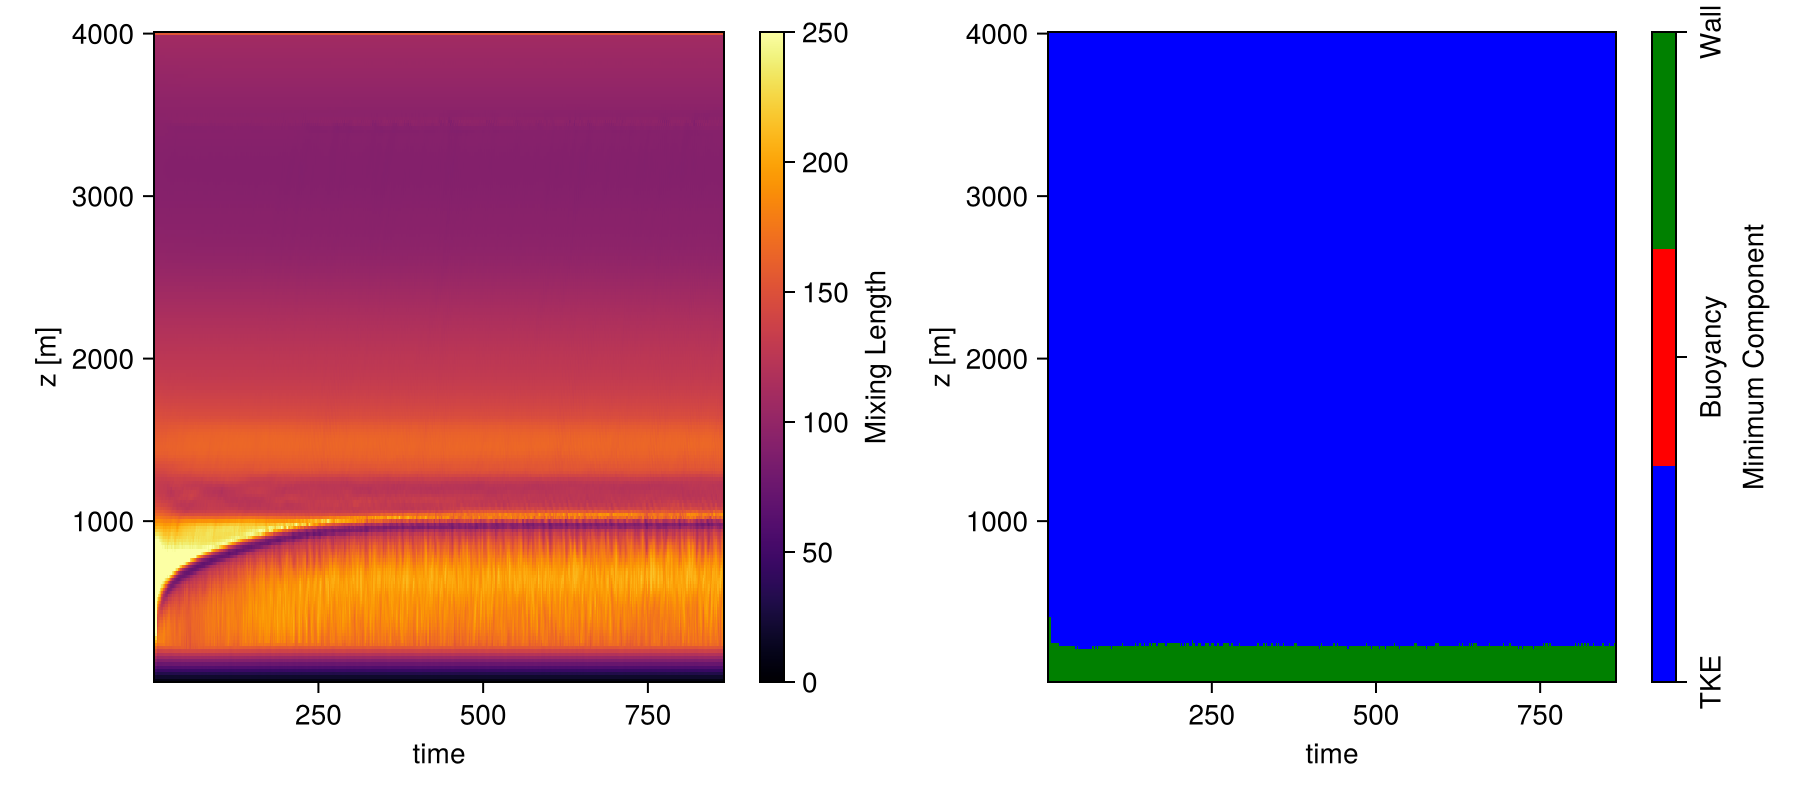

In [184]:
fig = Figure(size = (900, 400))

ax = Axis(fig[1, 1], ylabel = "z [m]", xlabel = "time")
hm = heatmap!(ax, 1:size(mlindep, 2), ds_profiles["z"][:], mlindep',
            colorrange=(0, 250),
            colormap = :inferno)
Colorbar(fig[1, 2], hm, label = "Mixing Length")

ax = Axis(fig[1,3], ylabel = "z [m]", xlabel = "time")
# Create a custom colormap for the three components
component_colors = [:blue, :red, :green]  # tke, buoy, wall
component_cmap = cgrad(component_colors, categorical=true)

# Get indices of minimum components (1=tke, 2=buoy, 3=wall)
mix_len_argmin = [argmin([m.tke, m.buoy, m.wall]) for m in ml]

# Plot with custom colormap and add colorbar with labels
hm = heatmap!(ax, 1:size(ml, 2), ds_profiles["z"][:], mix_len_argmin', 
    colormap=component_cmap,
    colorrange=(1, 3)
)
Colorbar(fig[1, 4], hm, 
    label="Minimum Component",
    ticks=(1:3, ["TKE", "Buoyancy", "Wall"]),
    labelrotation = π/2,
    ticklabelrotation = π/2
)


fig

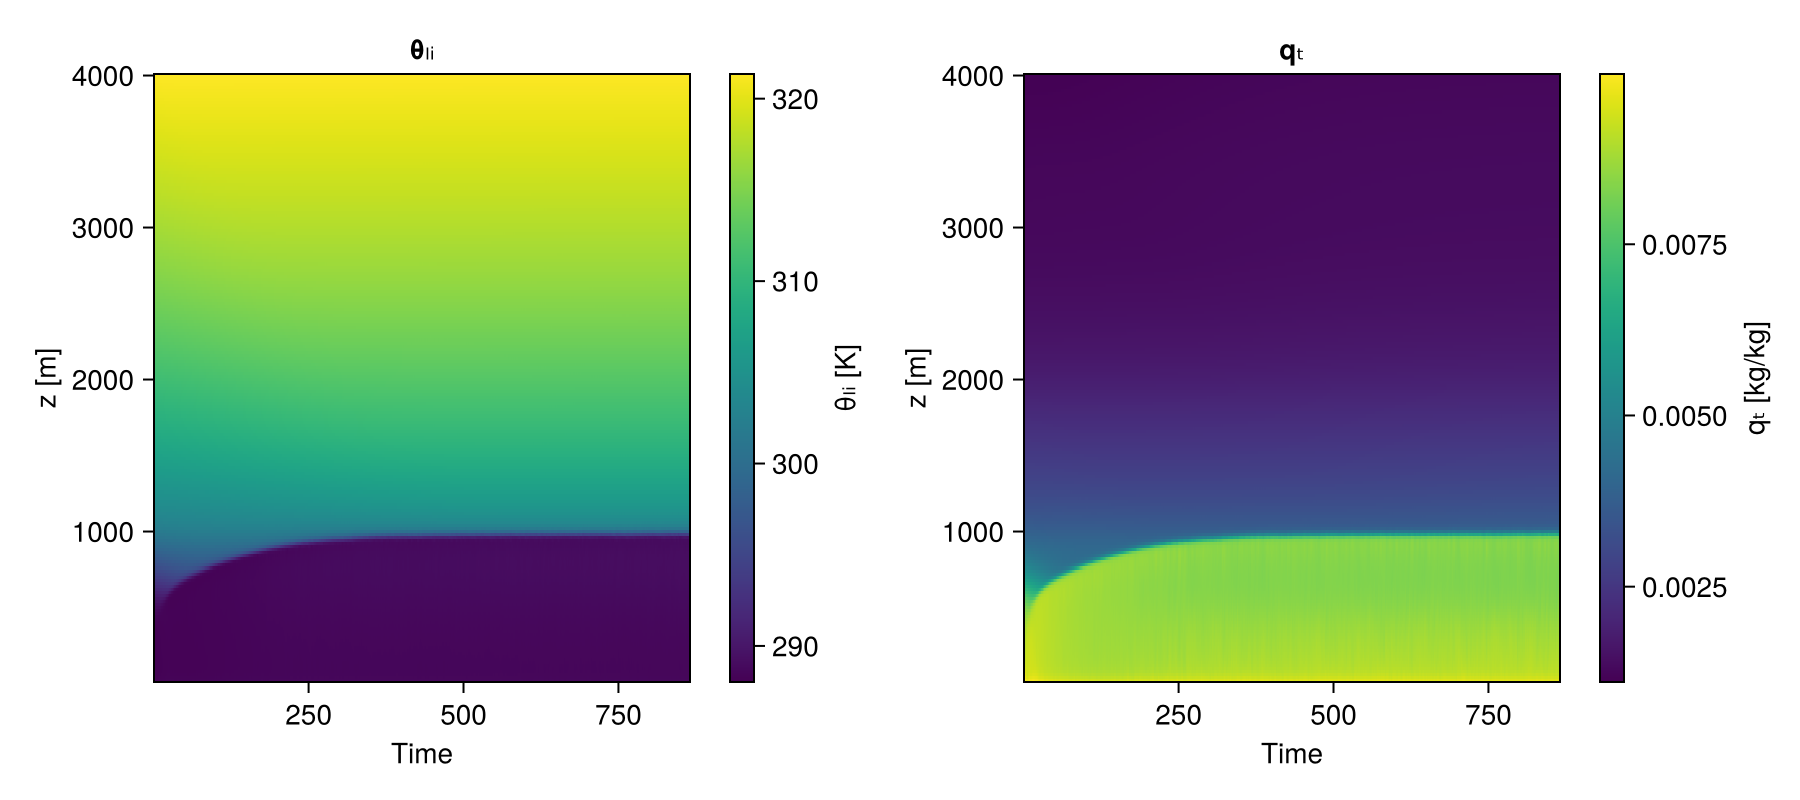

In [185]:
fig = Figure(size = (900, 400))

# First subplot for thetali_mean
ax1 = Axis(fig[1, 1], 
    xlabel = "Time",
    ylabel = "z [m]",
    title = "θₗᵢ"
)
hm1 = heatmap!(ax1, 
    1:size(ds_profiles["thetali_mean"], 2), 
    ds_profiles["z"][:], 
    ds_profiles["thetali_mean"][:, :]',
    colormap = :viridis
)
Colorbar(fig[1, 2], hm1, label = "θₗᵢ [K]")

# Second subplot for qt_mean
ax2 = Axis(fig[1, 3],
    xlabel = "Time",
    ylabel = "z [m]",
    title = "qₜ"
)
hm2 = heatmap!(ax2,
    1:size(ds_profiles["qt_mean"], 2),
    ds_profiles["z"][:],
    ds_profiles["qt_mean"][:, :]',
    colormap = :viridis
)
Colorbar(fig[1, 4], hm2, label = "qₜ [kg/kg]")

# Add gap between subplots
colgap!(fig.layout, 20)

fig

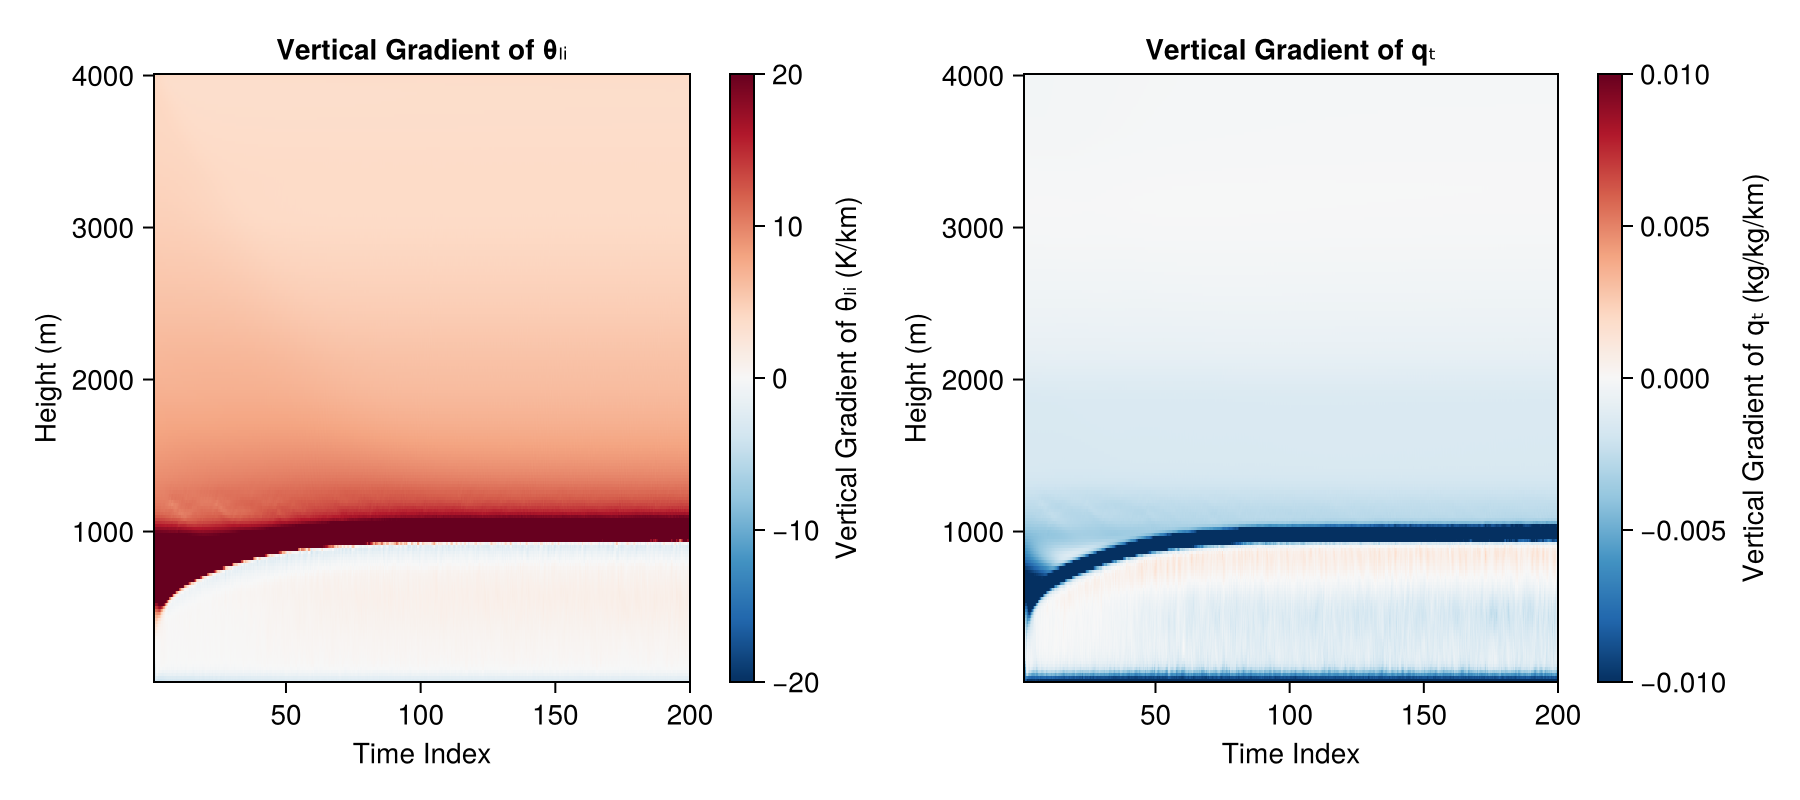

In [186]:
# Example usage:
z = ds_profiles["z"][:]
thetali_profile = ds_profiles["thetali_mean"][:, :]'
thetali_gradient = compute_vertical_gradient(thetali_profile, z)
qt_gradient = compute_vertical_gradient(ds_profiles["qt_mean"][:, :]', z)

# Create figure
fig = Figure(size=(900, 400))

# Add labels and title
ax = Axis(fig[1, 1],
    xlabel="Time Index",
    ylabel="Height (m)",
    title="Vertical Gradient of θₗᵢ"
)

# Create heatmap
hm = heatmap!(ax, 
    1:size(thetali_gradient, 2),
    z,
    thetali_gradient * 1000,
    colormap=reverse(cgrad(:RdBu)),  # Red-Blue diverging colormap
    colorrange=(-20, 20)  # Adjust range based on your data
)

# Create second subplot for qt gradient
ax2 = Axis(fig[1, 3],
    xlabel="Time Index",
    ylabel="Height (m)",
    title="Vertical Gradient of qₜ"
)

# Create heatmap for qt gradient
hm2 = heatmap!(ax2,
    1:size(thetali_gradient, 2),
    z,
    qt_gradient * 1000,  # Convert to per km, not meter
    colormap=reverse(cgrad(:RdBu)),
    colorrange=(-.01, .01)  # Adjust range based on your data
)

# Add colorbar for qt gradient
Colorbar(fig[1, 4], hm2, label = "Vertical Gradient of qₜ (kg/kg/km)")

# Adjust layout to accommodate both plots
colgap!(fig.layout, 20)  # Add gap between columns

# Add colorbar
Colorbar(fig[1, 2], hm, label = "Vertical Gradient of θₗᵢ (K/km)")

# Display figure
fig

In [209]:
# estimate the distance from the environment mean to saturation
import Thermodynamics as TD
ds_profiles["qt_mean"][:, :];
ds_profiles["temperature_mean"][:, :];
sat_hus = TD.q_vap_saturation.(CA.Parameters.thermodynamics_params(params), 
                    ds_profiles["temperature_mean"][:, :], 
                    1 ./ ds_profiles["alpha_mean"][:, :], 
                    TD.PhaseEquil)



200×865 Matrix{Float64}:
 0.011332   0.0114325  0.0114636   …  0.0116864  0.0116919  0.0116888
 0.0112047  0.0112645  0.0112965      0.0115337  0.0115388  0.0115361
 0.0110809  0.0111154  0.0111454      0.0113994  0.0114031  0.0114011
 0.0109616  0.0109731  0.0109977      0.0112759  0.0112776  0.0112768
 0.010845   0.0108415  0.0108565      0.0111609  0.0111605  0.0111608
 0.0107316  0.0107198  0.0107226   …  0.0110503  0.0110489  0.0110491
 0.0106219  0.0106056  0.0105975      0.0109422  0.0109407  0.0109401
 0.0105138  0.0104962  0.0104816      0.0108355  0.0108343  0.0108333
 0.0104079  0.0103898  0.0103728      0.0107303  0.0107293  0.0107283
 0.0103038  0.0102857  0.010268       0.0106268  0.0106258  0.0106248
 0.0102011  0.0101833  0.0101656   …  0.0105248  0.0105236  0.0105225
 0.0101     0.0100828  0.0100655      0.010424   0.0104225  0.0104218
 0.0100017  0.0099849  0.00996815     0.0103246  0.0103225  0.0103226
 ⋮                                 ⋱                        
 0.0

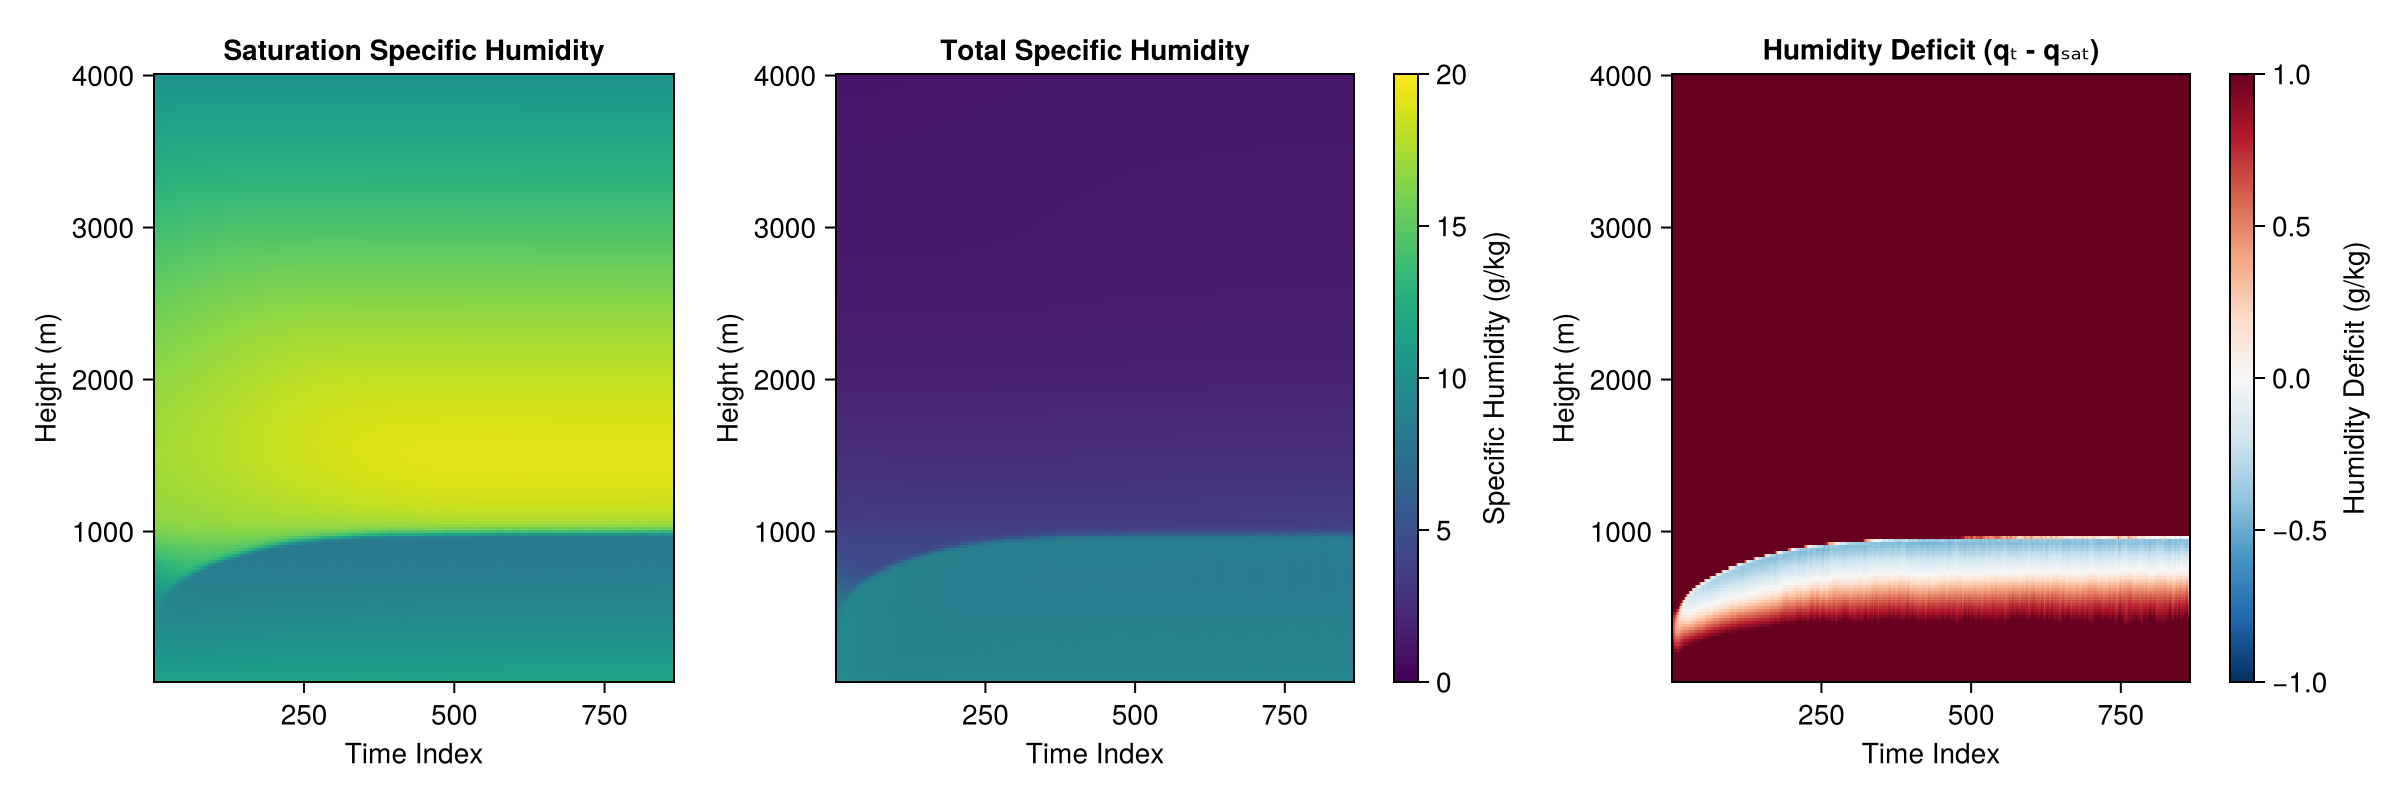

In [212]:
# Create figure with 3 panels
fig = Figure(size=(1200, 400))

# First panel - saturation specific humidity
ax1 = Axis(fig[1, 1],
    xlabel="Time Index",
    ylabel="Height (m)",
    title="Saturation Specific Humidity"
)

# Create heatmap for saturation humidity
hm1 = heatmap!(ax1,
    1:size(sat_hus, 2),
    z,
    sat_hus' * 1000,  # Convert to g/kg for better visualization
    colormap=cgrad(:viridis),
    colorrange=(0, 20)  # Adjust based on your data range
)

# Second panel - total specific humidity
ax2 = Axis(fig[1, 2],
    xlabel="Time Index",
    ylabel="Height (m)",
    title="Total Specific Humidity"
)

# Create heatmap for total humidity
hm2 = heatmap!(ax2,
    1:size(ds_profiles["qt_mean"], 2),
    z,
    ds_profiles["qt_mean"][:, :]' * 1000,  # Convert to g/kg
    colormap=cgrad(:viridis),
    colorrange=(0, 20)  # Match range with sat_hus
)

# Third panel - humidity deficit
ax3 = Axis(fig[1, 4],
    xlabel="Time Index",
    ylabel="Height (m)",
    title="Humidity Deficit (qₜ - qₛₐₜ)"
)

cmap = cgrad(
    [:blue, :blue, :red, :red],  # colors
    [0.0, 0.499, 0.501, 1.0],    # color stops
    categorical = true,           # make it categorical for sharp transitions
    rev = false
)

# Create heatmap for humidity deficit
hm3 = heatmap!(ax3,
    1:size(sat_hus, 2),
    z,
    (sat_hus - ds_profiles["qt_mean"][:, :])' * 1000,  # Convert to g/kg
    colormap=reverse(cgrad(:RdBu)),  # Red-Blue diverging colormap
    colorrange=(-1, 1)  # Adjust based on your data range
)

# Add colorbars
Colorbar(fig[1, 3], hm1, label = "Specific Humidity (g/kg)")
Colorbar(fig[1, 5], hm3, label = "Humidity Deficit (g/kg)")

# Adjust layout
colgap!(fig.layout, 20)  # Add gap between columns

# Display figure
fig

In [229]:
function objective(θ)
    # Create a thermodynamic state with this θ
    ts = TD.PhaseEquil_pθq(thermo_params, p, θ, q_tot)
    # Get the actual q_vap at this state
    #q_vap = TD.vapor_specific_humidity(thermo_params, ts)
    # Get the saturation q_vap at this state
    q_sat = TD.q_vap_saturation(thermo_params, ts)
    # Return difference between actual and saturation
    return q_vap - q_sat
end

# Test the objective function with some example values
p = 1.2  # Standard sea level pressure in Pa
q_tot = 0.01  # 10 g/kg total water content
θ_test = 280.0  # Test potential temperature

# Calculate the objective value
obj_value = objective(θ_test)
println("Objective value at θ = $θ_test: $obj_value")

# Try a few different θ values to see how the objective changes
θ_values = [200, 250, 275.0, 280.0, 285.0, 290.0, 300, 310]
for θ in θ_values
    obj = objective(θ)
    println("θ = $θ K: objective = $obj")
end

# This should help us understand if the objective function
# is behaving as expected - it should change sign between
# values where the air is subsaturated and supersaturated

Objective value at θ = 280.0: -1.3421302396685564e-56
θ = 200.0 K: objective = -6.07275538594884e-63
θ = 250.0 K: objective = -7.5663698497967115e-59
θ = 275.0 K: objective = -5.793806708152468e-57
θ = 280.0 K: objective = -1.3421302396685564e-56
θ = 285.0 K: objective = -3.081610462464318e-56
θ = 290.0 K: objective = -7.01412850473706e-56
θ = 300.0 K: objective = -3.5419304436133124e-55
θ = 310.0 K: objective = -1.730026706405227e-54


In [291]:
# repeat for the temperature calculation
using Roots

function objective(θ)
    # Create a thermodynamic state with this θ
    ts = TD.PhaseEquil_pθq(thermo_params, p, θ, q_tot)
    # Get the actual q_vap at this state
    q_vap = TD.vapor_specific_humidity(thermo_params, ts)
    # Get the saturation q_vap at this state
    q_sat = TD.q_vap_saturation(thermo_params, ts)
    # Return difference between actual and saturation
    return q_vap - q_sat
end

function find_condensation_thetali(thermo_params, p, q_tot)
    # First find the temperature where the air would be saturated
    # We can use PhaseEquil_pθq with a trial θ to get the temperature
    # where q_tot equals saturation
    

    
    # Initial guess: use a reasonable θ
    θ_guess = 280.0  # K
    
    # Find the θ where q_vap = q_sat
    θ_sat = find_zero(objective, θ_guess)
    println(θ_sat)
    
    # Now convert this to thetali
    ts_sat = TD.PhaseEquil_pθq(thermo_params, p, θ_sat, q_tot)
    thetali = TD.liquid_ice_pottemp(thermo_params, ts_sat)
    
    return thetali
end

# Example usage of find_condensation_thetali
thermo_params = CAP.thermodynamics_params(params)

# Get example pressure and total water content from the simulation
p_example = 1 ./ ds_profiles["alpha_mean"][1, 1]  # Take first timestep, first level
q_tot_example = ds_profiles["qt_mean"][1, 1]  # Take first timestep, first level

# Find the condensation thetali
thetali_cond = find_condensation_thetali.(thermo_params, p_example, q_tot_example)

println("Example pressure: ", p_example, " Pa")
println("Example total water content: ", q_tot_example, " kg/kg")
println("Condensation thetali: ", thetali_cond, " K")

# Compare with actual thetali from simulation
thetali_actual = ds_profiles["thetali_mean"][1, 1]
println("Actual thetali: ", thetali_actual, " K")
println("Difference: ", thetali_cond - thetali_actual, " K")


280.0


┌ Error: Failed to revise /home/jschmitt/experiments/cf/mixing_length.jl
│   exception =
│    MethodError: no method matching replace_coretypes_list!(::Vector{Any}; rev::Bool)
│    The function `replace_coretypes_list!` exists, but no method is defined for this combination of argument types.
│    Stacktrace:
│     [1] #replace_coretypes!#73
│       @ ~/.julia/packages/JuliaInterpreter/nxxiG/src/optimize.jl:269 [inlined]
│     [2] replace_coretypes!(src::Any)
│       @ JuliaInterpreter ~/.julia/packages/JuliaInterpreter/nxxiG/src/optimize.jl:267
└ @ Revise ~/.julia/packages/Revise/mLfYT/src/packagedef.jl:778


Example pressure: 1.213850862371726 Pa
Example total water content: 0.009397745317401715 kg/kg
Condensation thetali: (280.0,) K
Actual thetali: 288.16683287107554 K


LoadError: MethodError: no method matching -(::Tuple{Float64}, ::Float64)
The function `-` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.NotImplemented[39m, ::Any)
[0m[90m   @[39m [36mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/U6wNx/src/[39m[90m[4mtangent_arithmetic.jl:49[24m[39m
[0m  -(::Any, [91m::ChainRulesCore.NotImplemented[39m)
[0m[90m   @[39m [36mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/U6wNx/src/[39m[90m[4mtangent_arithmetic.jl:50[24m[39m
[0m  -([91m::ChainRulesCore.ZeroTangent[39m, ::Any)
[0m[90m   @[39m [36mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/U6wNx/src/[39m[90m[4mtangent_arithmetic.jl:101[24m[39m
[0m  ...


In [265]:
p_example = 1 ./ ds_profiles["alpha_mean"][:, :] .* 101325 # Take first timestep, first level

p_example = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][:, :] .* ds_profiles["temperature_mean"][:, :]
p_example

200×865 Matrix{Float64}:
     1.00791e5  100769.0        …       1.00781e5      1.00781e5
     1.00559e5       1.00544e5          1.00558e5      1.00558e5
     1.00327e5       1.00317e5     100331.0            1.00332e5
     1.00094e5       1.00089e5          1.00103e5      1.00103e5
 99861.6         99859.1            99872.5        99872.5
 99629.1         99628.4        …   99641.4        99641.2
 99396.8         99396.9            99410.0        99409.6
 99164.7         99165.1            99178.6        99178.1
 98933.0         98933.6            98947.4        98946.9
 98701.7         98702.3            98716.5        98716.0
 98470.7         98471.3        …   98485.8        98485.5
 98240.1         98240.8            98255.5        98255.4
 98009.9         98010.6            98025.6        98025.8
     ⋮                          ⋱                  
 63897.9         63897.9            63892.9        63892.9
 63734.6         63734.6            63729.6        63729.6
 63571.7      

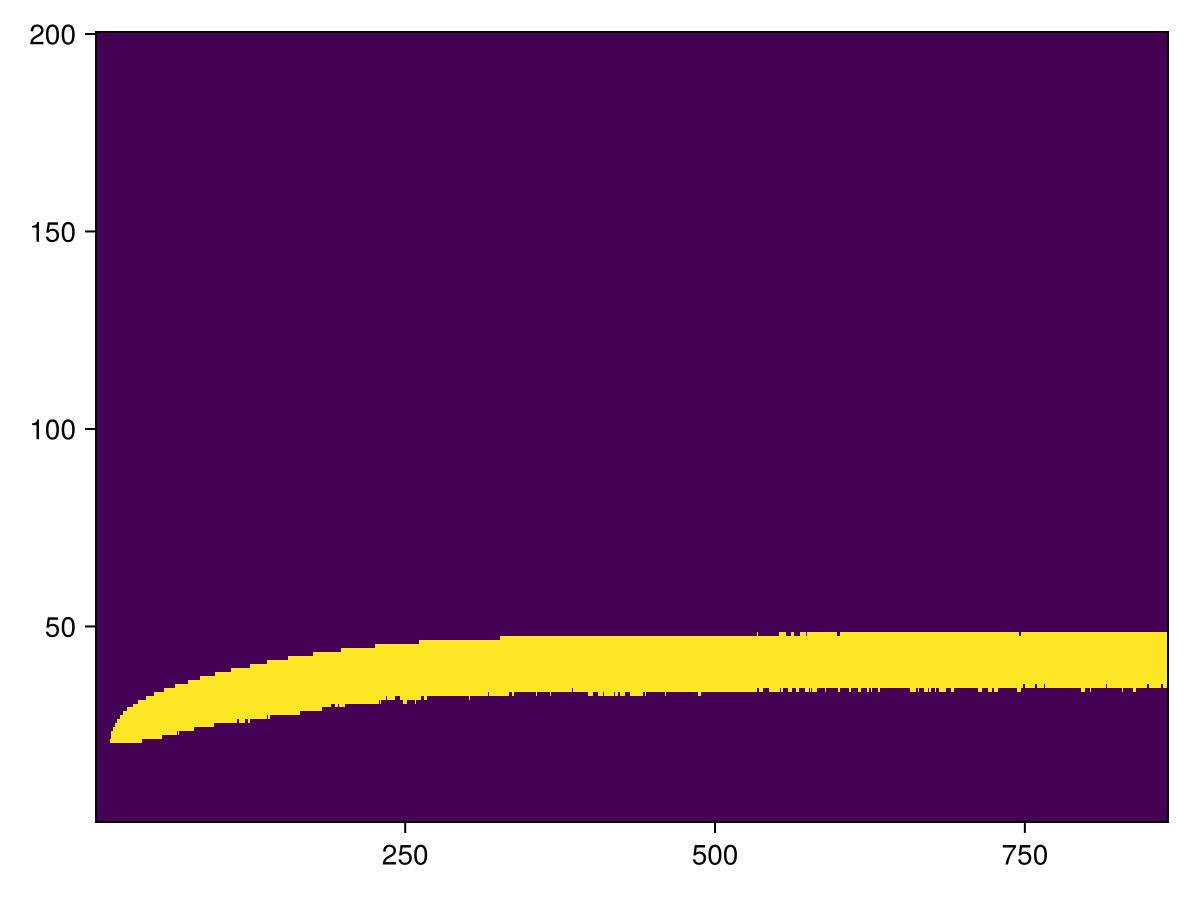

In [272]:
p_example = CAP.R_d(params) .* 1 ./ ds_profiles["alpha_mean"][:, :] .* ds_profiles["temperature_mean"][:, :]
q_tot_example = ds_profiles["qt_mean"][:, :]
theta_li_example = ds_profiles["thetali_mean"][:, :]
FT = Float32
example_ts = TD.PhaseEquil_pθq.(thermo_params,
                    p_example,#p_example,
                    theta_li_example,
                    q_tot_example
                    )

# compute the condensate
heatmap(TD.has_condensate.(thermo_params, example_ts)') #.== q_tot_example

In [288]:
# Function to find the liquid-ice potential temperature at which condensation occurs
function find_condensation_thetali(thermo_params, p, q_tot)
    # Objective function: returns 0 when condensation starts
    function objective(θ_li)
        ts = TD.PhaseEquil_pθq(thermo_params, p, θ_li, q_tot)
        return TD.has_condensate(thermo_params, ts) ? 1.0 : -1.0
    end
    
    # Initial θ_li guess (can be adjusted based on typical values)
    θ_li_guess = 280.0  # K
    
    # Use Roots.jl to find where objective function crosses zero
    # This will be the θ_li where condensation begins
    # Provide a bracket for bisection to ensure distinct values
    θ_li_min = θ_li_guess - 100.0  # Lower bound
    θ_li_max = θ_li_guess + 100.0  # Upper bound
    
    # Use Roots.jl with explicit bracket and relaxed tolerance
    θ_li_cond = find_zero(objective, (θ_li_min, θ_li_max), Bisection())
    
    return θ_li_cond
end

# Example usage
θ_li_cond = find_condensation_thetali.(thermo_params, p_example, q_tot_example)

# Compare with actual θ_li
θ_li_actual = ds_profiles["thetali_mean"][:, :];

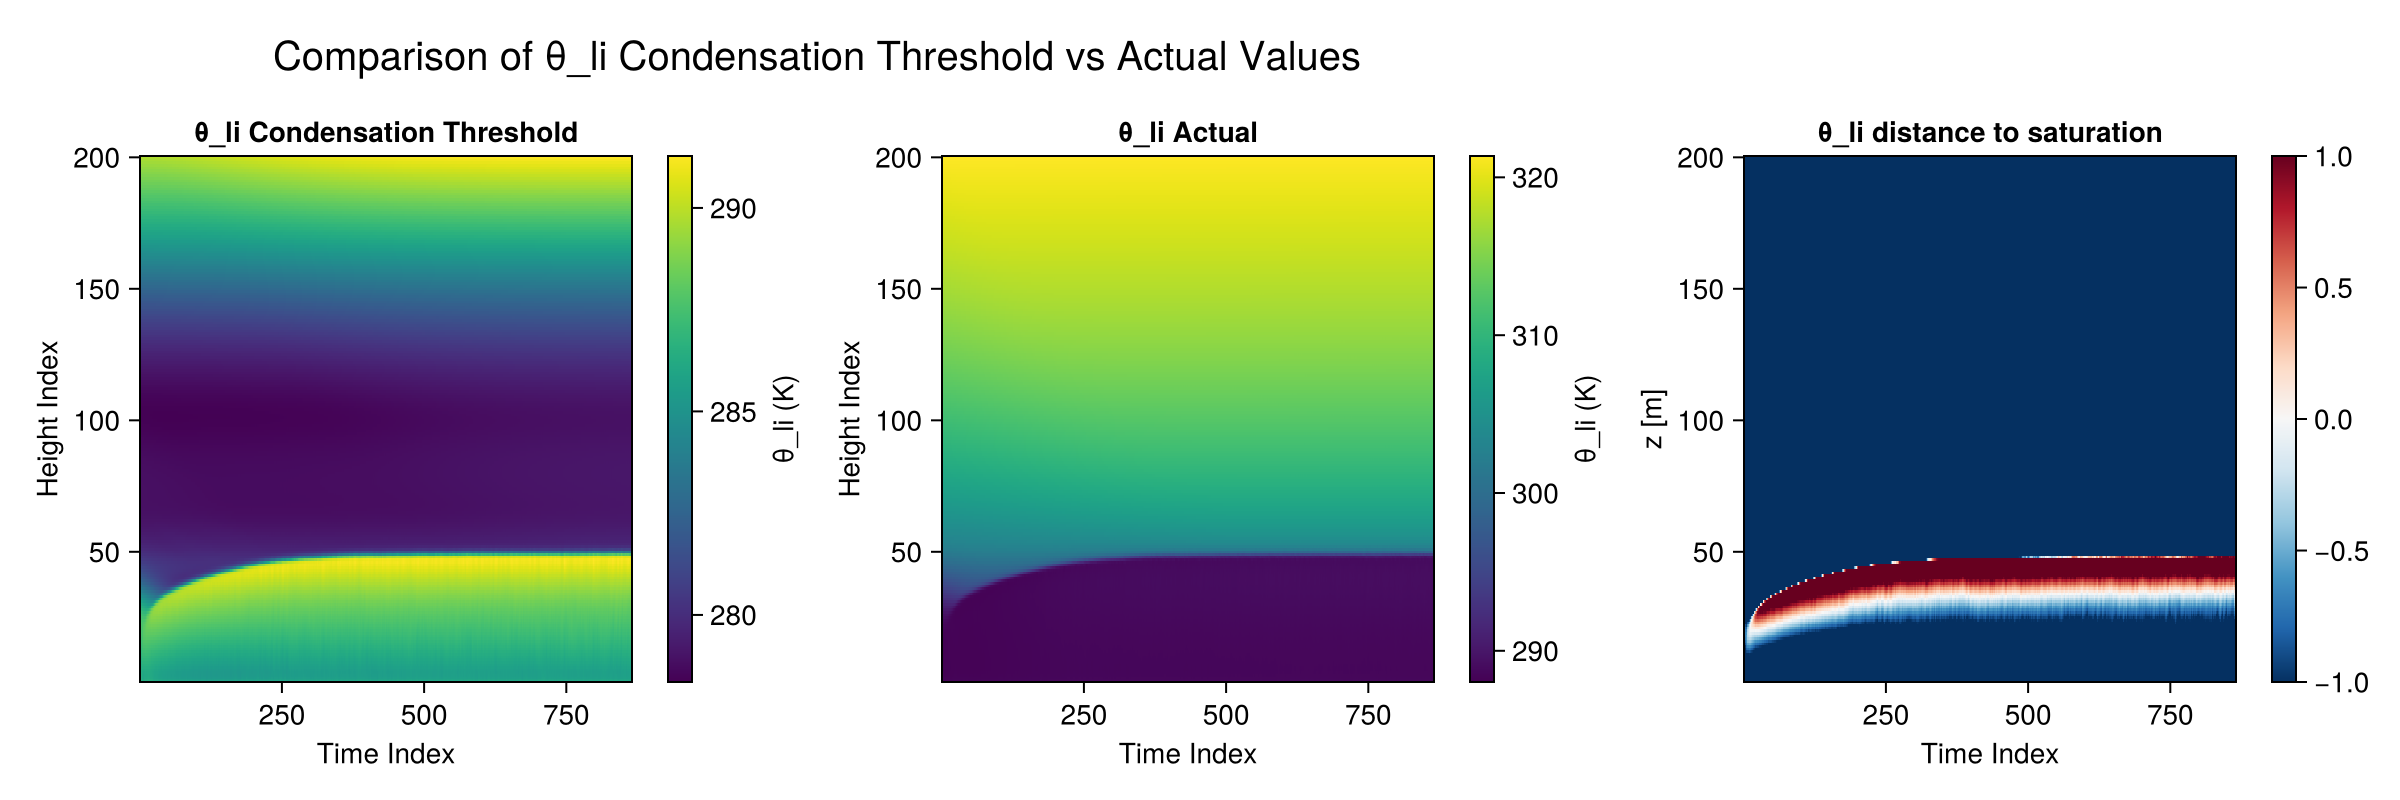

In [289]:
# Create figure with two side-by-side heatmaps
fig = Figure(size=(1200, 400))

# Left heatmap: θ_li condensation threshold
ax1 = Axis(fig[1, 1], 
    title="θ_li Condensation Threshold",
    xlabel="Time Index",
    ylabel="Height Index"
)
hm1 = heatmap!(ax1, θ_li_cond')
Colorbar(fig[1, 2], hm1, label="θ_li (K)")

# Right heatmap: θ_li actual
ax2 = Axis(fig[1, 3],
    title="θ_li Actual",
    xlabel="Time Index",
    ylabel="Height Index"
)
hm2 = heatmap!(ax2, θ_li_actual')
Colorbar(fig[1, 4], hm2, label="θ_li (K)")

# Add a title for the whole figure
Label(fig[0, :], "Comparison of θ_li Condensation Threshold vs Actual Values", 
    fontsize=20)

ax3 = Axis(fig[1, 5],
    title = "θ_li distance to saturation",
    xlabel = "Time Index",
    ylabel = "z [m]"
)

hm3 = heatmap!(ax3, 
    (θ_li_cond .- θ_li_actual)',
    colormap=reverse(cgrad(:RdBu)),  # Red-Blue diverging colormap
    colorrange=(-1, 1)  # Adjust based on your data range
)
Colorbar(fig[1,6], hm3)

fig
